In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from keras.applications import VGG16
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Multiply,Reshape
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import tensorflow 

from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101 # ResNet 101
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import time

In [4]:
def create_df(dataset_path, output_csv):
    
    data = []
    
    for category in os.listdir(dataset_path):
        category_path = os.path.join(dataset_path, category)
        
        if os.path.isdir(category_path):
            for image_name in os.listdir(category_path):
                image_path = os.path.join(category_path, image_name)
                
                data.append({"image_path": image_path, "category": category})
    
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"CSV file saved as {output_csv}")
    return df

# augmented dataset 
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"
output_csv = "dataset.csv"
df=create_df(dataset_path,output_csv)
df.head()

CSV file saved as dataset.csv


image_path          category
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented

In [5]:
# original
o_dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"
output_csv = "dataset_o.csv"
df_o=create_df(o_dataset_path,output_csv)
df_o.head()

CSV file saved as dataset_o.csv


image_path          category
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  ModerateDemented

In [6]:
def plot_bar(df_c,title):
    graph=df_c.groupby(["category"]).agg("count").reset_index()
    # Counting the occurrences of each class label
    category_counts = graph["category"].value_counts()
    plt.bar( ['Mild','Moderate','None','Very Mild'],  graph["image_path"])
    plt.xticks(['Mild','Moderate','None','Very Mild'])
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()
    return graph.rename(columns={"image_path": "count"})

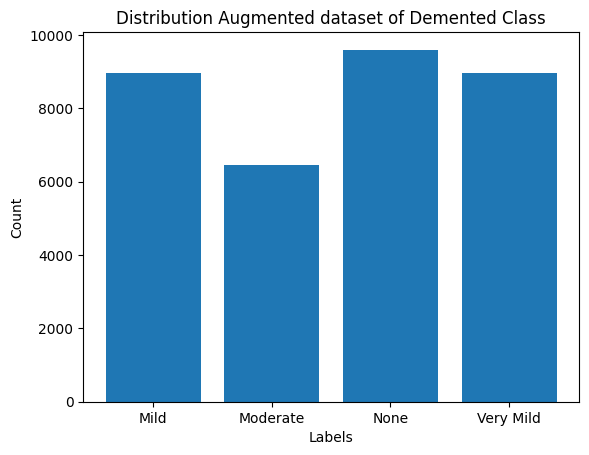

category  count
0      MildDemented   8960
1  ModerateDemented   6464
2       NonDemented   9600
3  VeryMildDemented   8960

In [7]:
graph =  plot_bar(df,'Distribution Augmented dataset of Demented Class' )
graph

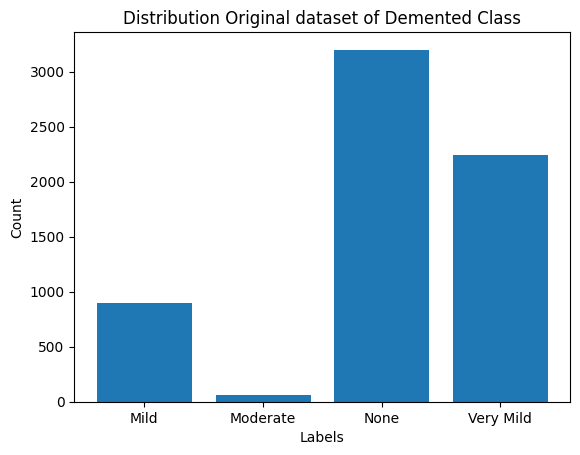

category  count
0      MildDemented    896
1  ModerateDemented     64
2       NonDemented   3200
3  VeryMildDemented   2240

In [8]:
graph_o =  plot_bar(df_o,'Distribution Original dataset of Demented Class' )
graph_o

In [10]:
def show_random_images(column, number_of_images_to_show=5,df=df, grey=False):
    categories = df["category"].unique()
    
    images_per_category = number_of_images_to_show
    
    plt.figure(figsize=(15, len(categories) * 5))
    for i, category in enumerate(categories):
        category_images = df[df["category"] == category][column].tolist()
        
        for j in range(min(len(category_images), images_per_category)):
            img_data = category_images[j]
            if column != "image_path":
                img = img_data
            else:
                img = cv2.imread(img_data)
                
            if column == "image_path":
                if grey:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                else:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            plt.subplot(len(categories), images_per_category, i * images_per_category + j + 1)
            
            if grey:
                plt.imshow(img, cmap="gray")
            else:
                plt.imshow(img)
            
            plt.axis("off")
            plt.title(f"{category}")
    
    plt.tight_layout()
    plt.show()

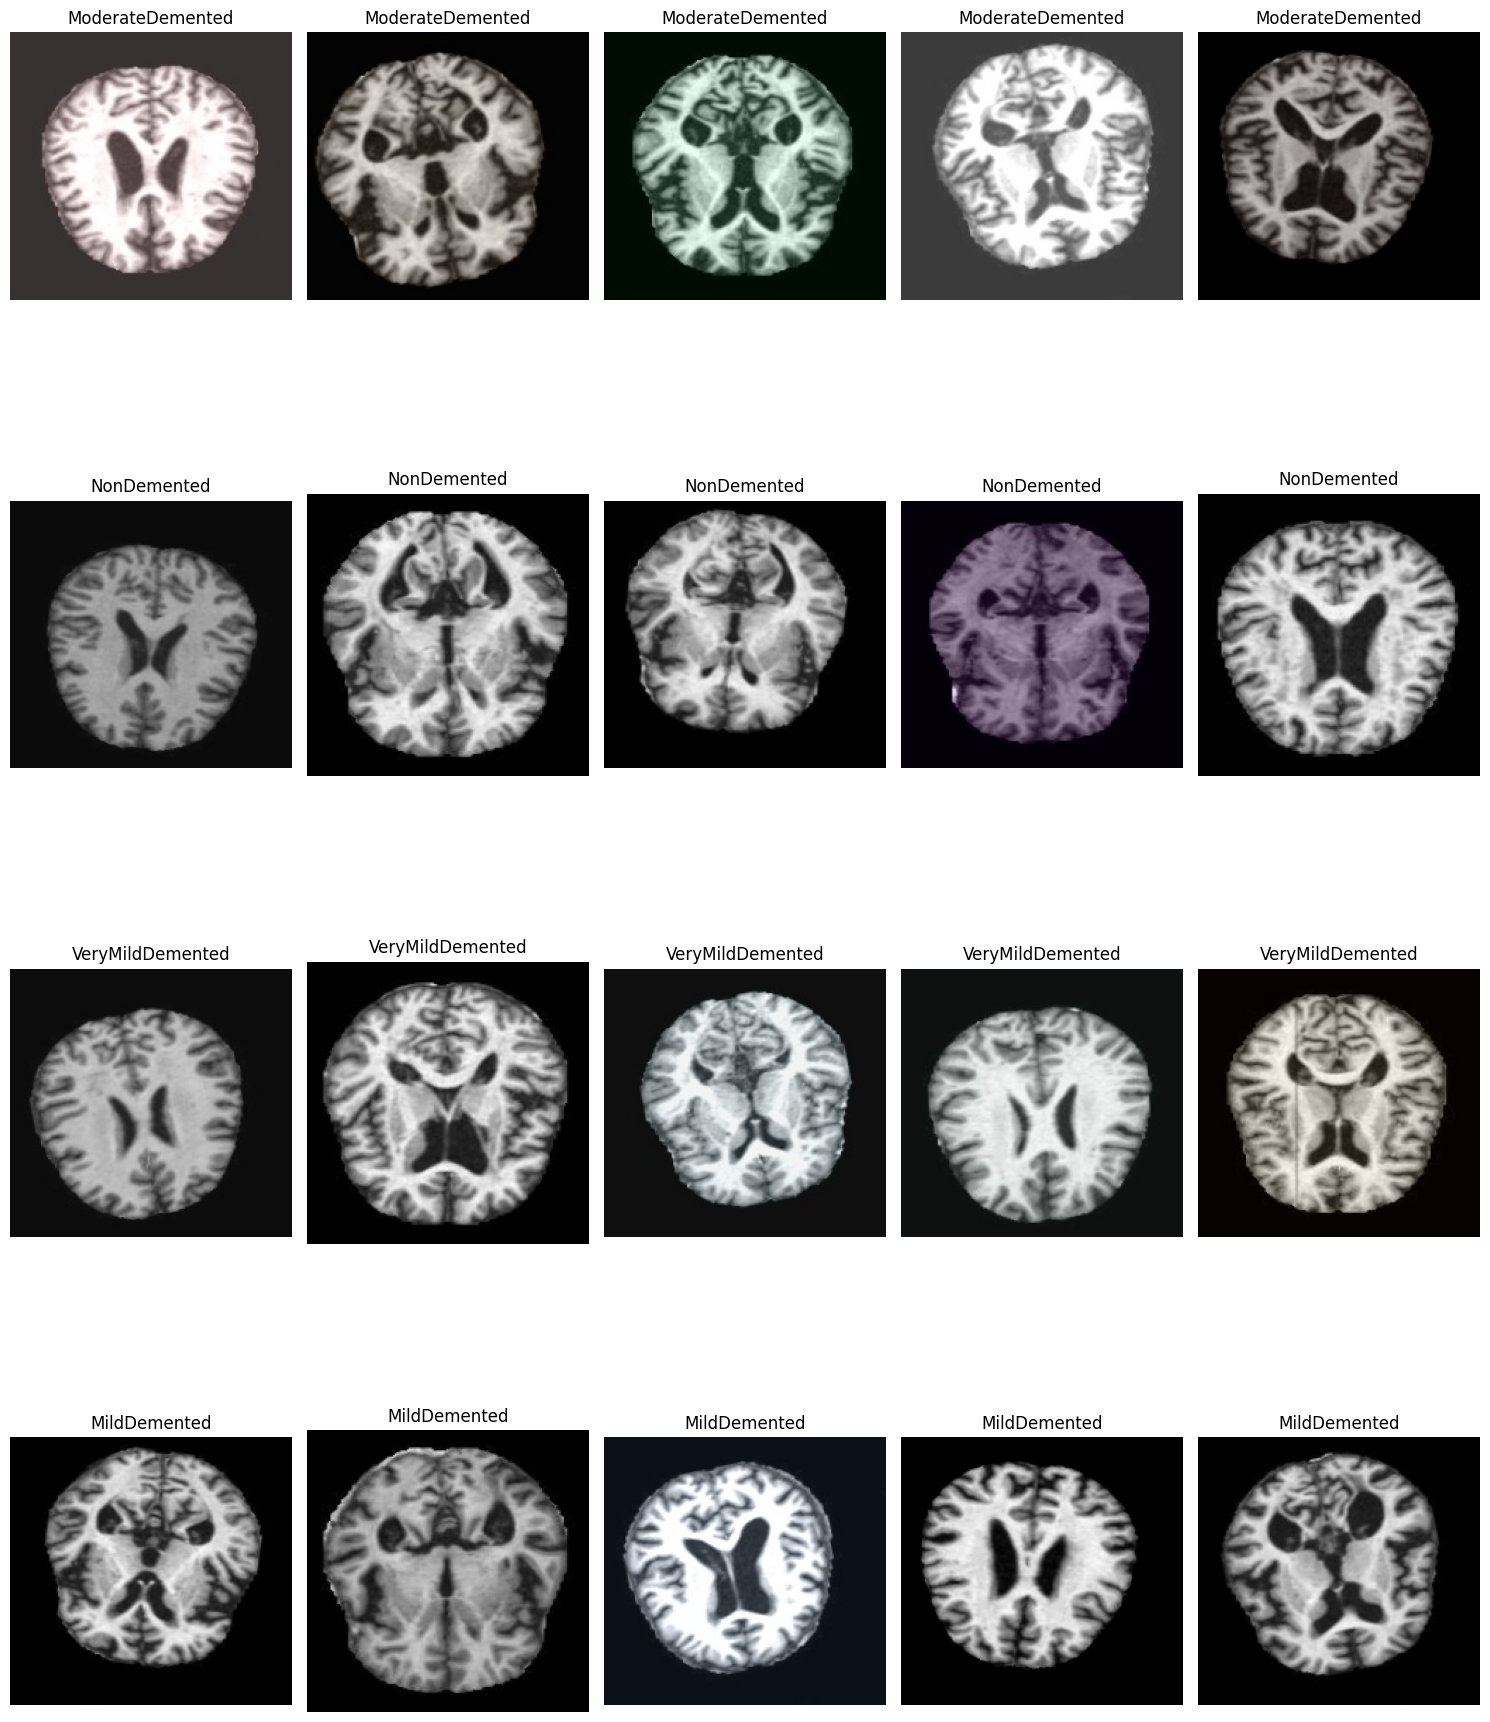

In [11]:
show_random_images("image_path", 5, df,False) # augmented

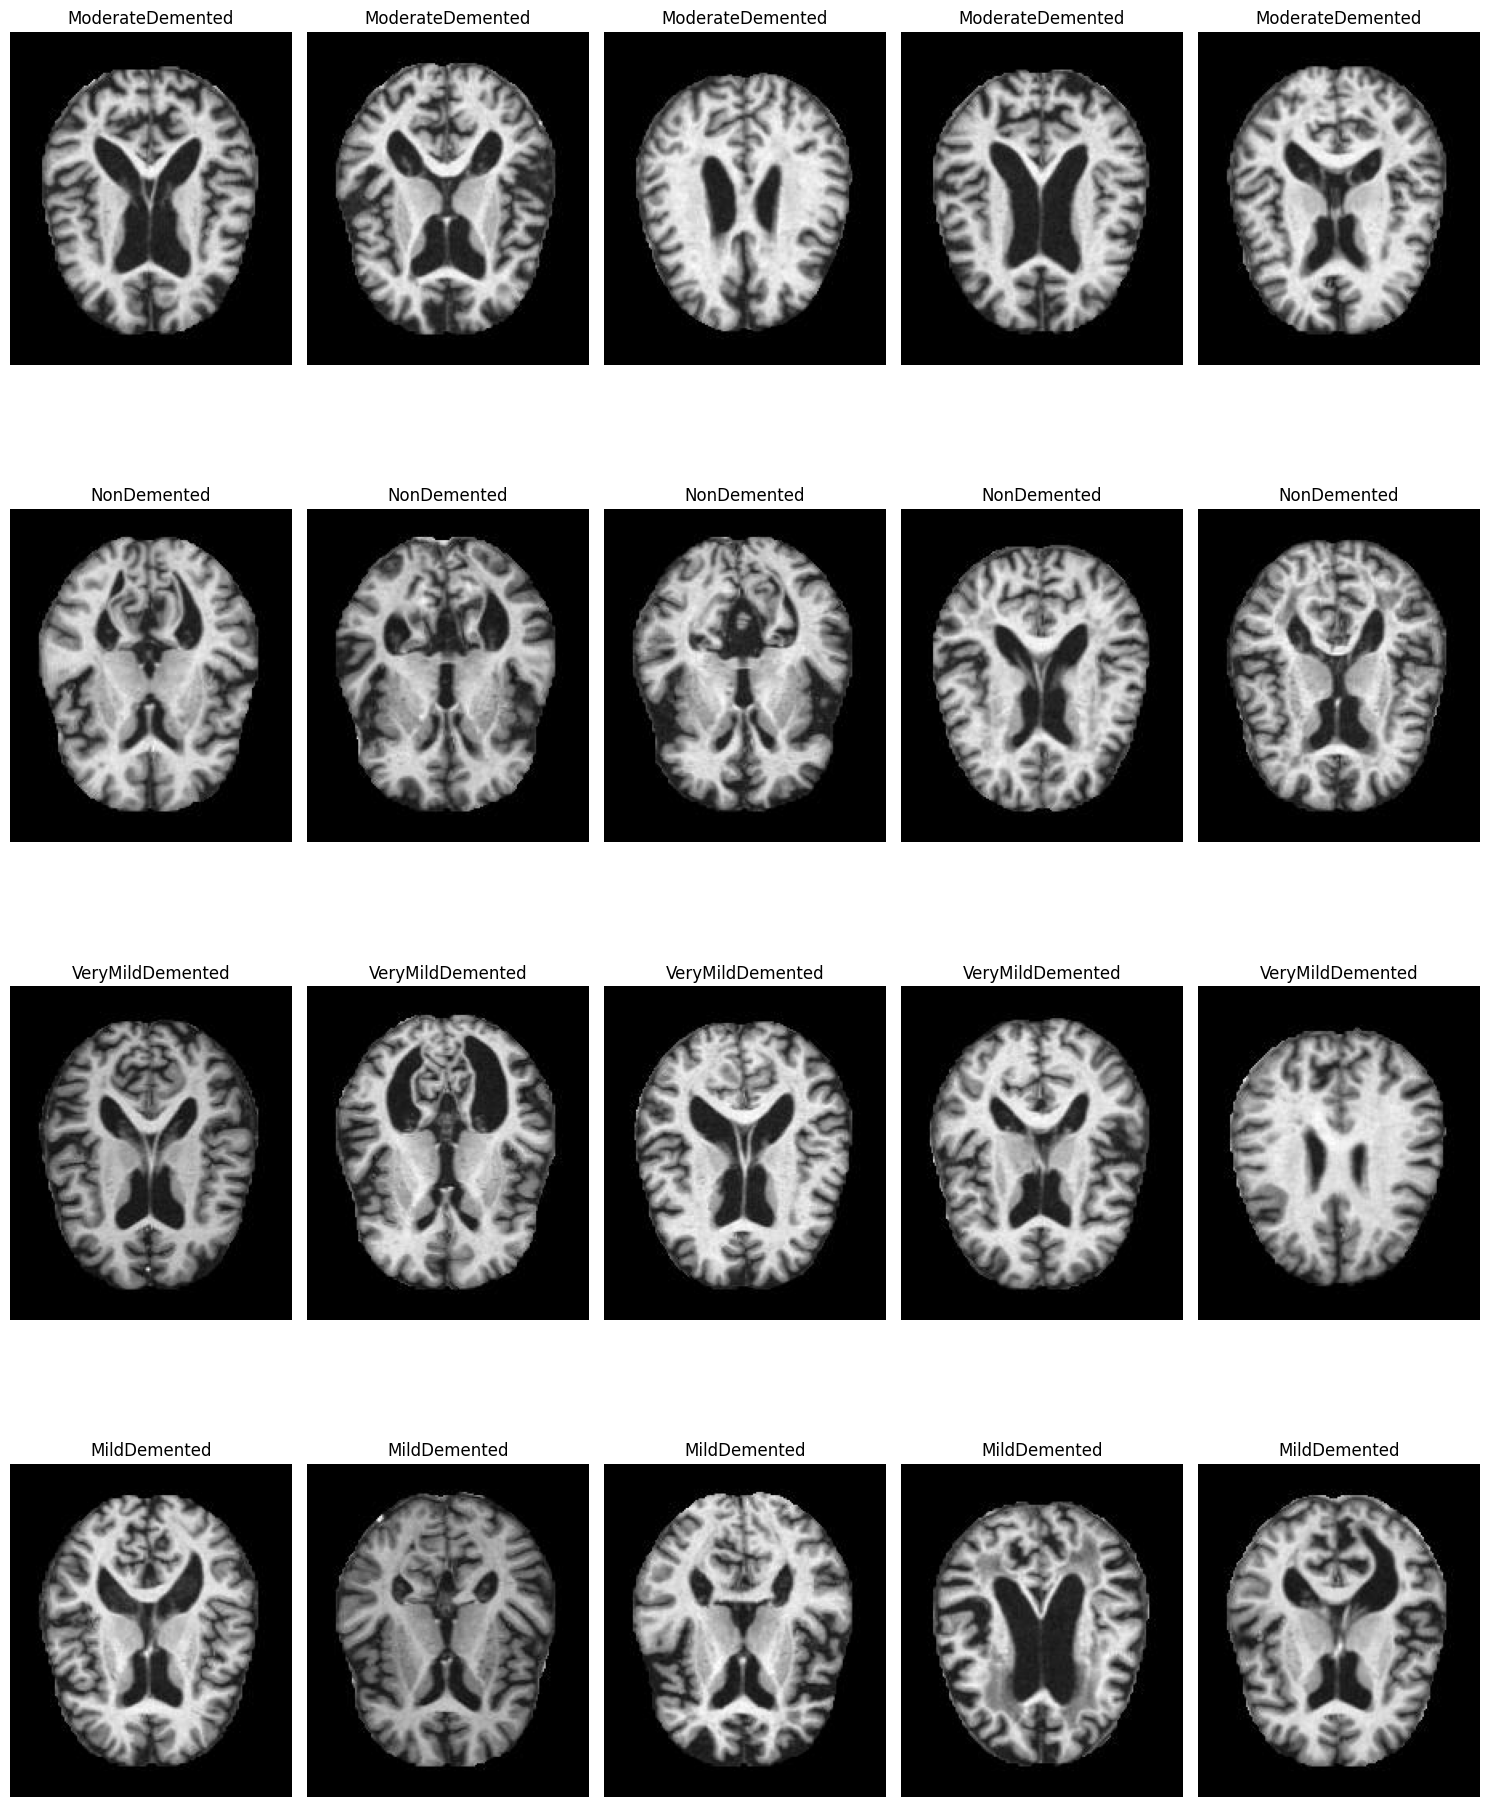

In [12]:
show_random_images("image_path", 5, df_o,False) # original

In [13]:
CLASSES =  ['Mild','Moderate','None','Very Mild']
IMG_SIZE = 128
IMAGE_SIZE = [ 128,  128]
DIM = (IMG_SIZE, IMG_SIZE)

In [14]:
datagen = IDG(rescale = 1./255, validation_split=0.1)

train_gen = datagen.flow_from_directory(directory=dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical',
                                             subset='training',
                                             shuffle=True)

validation_gen = datagen.flow_from_directory(directory=dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical',
                                             subset='validation',
                                             shuffle=True)

test_gen = datagen.flow_from_directory(directory=o_dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')


Found 30586 images belonging to 4 classes.
Found 3398 images belonging to 4 classes.
Found 6400 images belonging to 4 classes.


In [15]:
test_gen_plot = datagen.flow_from_directory(directory=o_dataset_path,
                                             target_size=DIM,
                                             batch_size=128,
                                             class_mode='categorical')


Found 6400 images belonging to 4 classes.


In [16]:
# pretrain model
vgg = VGG16(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          32,772 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,747,460 (56.26 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [17]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=100, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


239/239 ━━━━━━━━━━━━━━━━━━━━ 160s 601ms/step - acc: 0.5107 - auc: 0.7674 - loss: 1.1228 - val_acc: 0.7048 - val_auc: 0.9162 - val_loss: 0.7384
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 121us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,auc,loss
  current = self.get_monitor_value(logs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 49s 197ms/step - acc: 0.7025 - auc: 0.9144 - loss: 0.7300 - val_acc: 0.7163 - val_auc: 0.9238 - val_loss: 0.6695
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 71us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 51s 208ms/step - acc: 0.7525 - auc: 0.9393 - loss: 0.6237 - val_acc: 0.7604 - val_auc: 0.9431 - val_loss: 0.5877
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - acc: 0.7790 - auc: 0.9511 - loss: 0.5593 - val_acc: 0.7354 - val_auc: 0.9350 - val_loss: 0.6069
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 88us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 52s 210ms/step - acc: 0.7995 - auc: 0.9580 - loss: 0.5203 - val_acc: 0.8040 - val_auc: 0.9597 - val_loss: 0.5042
Epoch 10/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 92us/step - acc: 0.0000e

In [18]:
def plot_training_metrics(train_hist, model, test_gen_plot, y_actual, y_pred, classes, model_name):
    """
    Input: trained model history, model, test image generator, actual and predicted labels, class list
    Output: Plots loss vs epochs, accuracy vs epochs, confusion matrix
    """
    
    # Evaluate the results: 
    #. test_metrics[0] = loss, 
    #  test_metrics[1] = auc, 
    #  test_metrics[2] = acc
    # Evaluate the results:
    test_metrics = model.evaluate(test_gen_plot, verbose = False)
    AUC       = test_metrics[1]*100
    Acc       = test_metrics[2]*100 
    results_title =(f"\n Model AUC {AUC:.2f}%, Accuracy {Acc:.2f}% on Test Data\n")
    print(results_title.format(AUC, Acc))
    
    # print classification report
    print(classification_report(y_actual, y_pred, target_names=classes))

    # extract data from training history for plotting
    history_dict    = train_hist.history
    loss_values     = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    auc_values      = history_dict['auc']
    val_auc_values  = history_dict['val_auc']
    epochs          = range(1, len(history_dict['auc']) + 1)

    # get the min loss and max accuracy for plotting
    max_auc = np.max(val_auc_values)
    min_loss = np.min(val_loss_values)
    
    # create plots
    plt.subplots(figsize=(12,4))
    
    # plot loss by epochs
    plt.subplot(1,3,1)
    plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
    plt.plot(epochs, val_loss_values, 'cornflowerblue', label = 'Validation loss')
    plt.title('Validation Loss by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.axhline(y=min_loss,color='darkslategray', linestyle='--')
    plt.legend()
        # plot accuracy by epochs
    plt.subplot(1,3,2)
    plt.plot(epochs, auc_values, 'bo',label = 'Training AUC')
    plt.plot(epochs, val_auc_values, 'cornflowerblue', label = 'Validation AUC')
    plt.plot(epochs,[AUC/100]*len(epochs),'darkmagenta',linestyle = '--',label='Test AUC')
    plt.title('Validation AUC by Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.axhline(y=max_auc,color='darkslategray', linestyle='--')
    plt.legend()
    
     # calculate Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    # create confusion matrix plot
    plt.subplot(1,3,3)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuPu)
    plt.title(f"Confusion Matrix \nAUC: {AUC:.2f}%")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # loop through matrix, plot each 
    threshold = cm.max() / 2.

    for r, c in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(c, r, format(cm[r, c], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[r, c] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f"{model_name}.pdf")

    plt.show()

In [19]:
def prepare_for_test(model, test_gen):
    data, y_true = next(test_gen)
    y_pred_ = model.predict(data, batch_size = 64)
    y_pred = []
    for i in range(y_pred_.shape[0]):
        y_pred.append(np.argmax(y_pred_[i]))
        
    y_true = np.argmax(y_true, axis=1)
    
    return y_true, y_pred


2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step

 Model AUC 98.77%, Accuracy 90.00% on Test Data

              precision    recall  f1-score   support

        Mild       0.71      1.00      0.83        15
    Moderate       1.00      1.00      1.00         2
        None       0.90      0.88      0.89        59
   Very Mild       0.89      0.81      0.85        52

    accuracy                           0.87       128
   macro avg       0.88      0.92      0.89       128
weighted avg       0.88      0.87      0.87       128



<ipython-input-18-ba437e3ded20>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

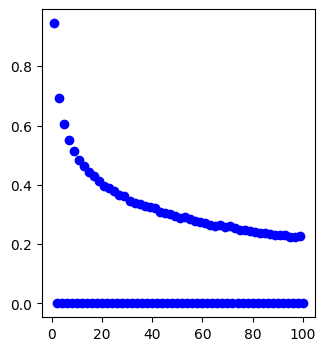

In [20]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, CLASSES, model_name = "vgg16")


In [21]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')
# SAVE MODEL
model_dir = "./alzheimer_vgg16_model"
#model.save(model_dir, save_format='h5')
model.save('./alzheimer_vgg16_model/my_vgg16_history.h5')
np.save('my_vgg16_history.npy', history.history)

In [22]:
#load model
new_model = tensorflow.keras.models.load_model('./alzheimer_vgg16_model/my_vgg16_history.h5')
# Show the model architecture
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          32,772 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 14,747,462 (56.26 MB)

 Trainable params: 32,772 (128.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

## ResNet50

In [23]:
# pretrain model
res = ResNet50(input_shape=(128,128,3), weights='imagenet', include_top=False)
for layer in res.layers:
    layer.trainable = False
x = Flatten()(res.output)

prediction = Dense(4, activation='softmax')(x)

model = Model(inputs=res.input, outputs=prediction)
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,718,788 (90.48 MB)

 Trainable params: 131,076 (512.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [24]:
model.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

tic = time.perf_counter()
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=validation_gen,
                    validation_steps=len(validation_gen),
                    epochs=100, callbacks=callback)
# time
toc = time.perf_counter()
print("Total Time:{}".format(round((toc-tic)/60,2)))

Epoch 1/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 63s 217ms/step - acc: 0.3775 - auc: 0.6544 - loss: 1.2966 - val_acc: 0.5647 - val_auc: 0.8198 - val_loss: 1.0698
Epoch 2/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 195us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: acc,auc,loss
  current = self.get_monitor_value(logs)


239/239 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step - acc: 0.5362 - auc: 0.7966 - loss: 1.0777 - val_acc: 0.5792 - val_auc: 0.8317 - val_loss: 1.0010
Epoch 4/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 100us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 42s 173ms/step - acc: 0.5691 - auc: 0.8255 - loss: 1.0049 - val_acc: 0.6024 - val_auc: 0.8508 - val_loss: 0.9470
Epoch 6/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 115us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - acc: 0.5953 - auc: 0.8448 - loss: 0.9551 - val_acc: 0.5959 - val_auc: 0.8522 - val_loss: 0.9285
Epoch 8/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 98us/step - acc: 0.0000e+00 - auc: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 44s 177ms/step - acc: 0.5937 - auc: 0.8442 - loss: 0.9431 - val_acc: 0.6054 - val_auc: 0.8582 - val_loss: 0.9075
Epoch 10/100
239/239 ━━━━━━━━━━━━━━━━━━━━ 0s 113us/step - acc: 0.00

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

 Model AUC 88.49%, Accuracy 64.97% on Test Data

              precision    recall  f1-score   support

        Mild       0.51      0.95      0.67        19
    Moderate       0.50      1.00      0.67         1
        None       0.82      0.59      0.69        69
   Very Mild       0.59      0.62      0.60        39

    accuracy                           0.66       128
   macro avg       0.60      0.79      0.66       128
weighted avg       0.70      0.66      0.66       128



<ipython-input-18-ba437e3ded20>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

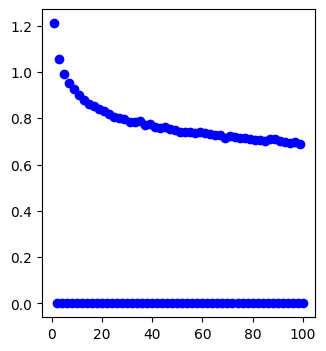

In [25]:
y_true, y_pred = prepare_for_test(model, test_gen)
plot_training_metrics(history, model, test_gen_plot, y_true, y_pred, CLASSES, model_name = "res")


In [26]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model_res.keras')
# SAVE MODEL
model_dir = "./alzheimer_res_model"
#model.save(model_dir, save_format='h5')
model.save('./alzheimer_res_model/res_history.h5')
np.save('res_history.npy', history.history)

## Explainability NeuroXAI 

In [45]:
def get_last_layer(model):
    last_layer = model.layers[-1]
    return last_layer

In [46]:
def load_images_2d(im, IM_SIZE=128):
    #if type(im)!=np.ndarray:
    im = cv2.imread(im) # read the image from the path

    new_im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #plt.imshow(new_im)
    new_im = cv2.resize(new_im, (IM_SIZE, IM_SIZE))

    new_im = np.array(new_im) / 128.0
    new_im = new_im[np.newaxis, ...]
    return new_im

In [47]:
CLASSES 

['Mild', 'Moderate', 'None', 'Very Mild']

In [48]:
def compute_grads(model, io_imgs_, class_id, LAYER_NAME=None, MODALITY='Mild', XAI_MODE="classification"):
    modality_dict = {'Mild': 0, 'Moderate': 1, 'None': 2, 'Very Mild': 3}
   # io_imgs_ = io_imgs_[ None,:,:,:] 
    io_imgs = tensorflow.convert_to_tensor(io_imgs_)
    io_imgs =tensorflow.cast(io_imgs, tensorflow.float32)
    io_imgs = tensorflow .reshape(io_imgs, shape=[-1, 128,128,3])
    #io_imgs=tensorflow.cast(io_imgs, tensorflow.int64)
  #  print(io_imgs.shape)
    with tensorflow.GradientTape() as tape:
        tape.watch(io_imgs)

        last_layer = get_last_layer(model)
        if LAYER_NAME == None or LAYER_NAME == last_layer.name:
            predictions = model(io_imgs)
            print(predictions)
            if XAI_MODE == "classification":
                class_id=tensorflow.cast(class_id, tensorflow.float32)
                predictions = predictions[:,modality_dict[MODALITY]]
            elif XAI_MODE == "segmentation":
                predictions = predictions[:,:,:,class_id.astype(int)]
                    
            gradients = np.array(tape.gradient(predictions, io_imgs))
        else:
            conv_outputs, predictions = model(io_imgs_)
            gradients = np.array(tape.gradient(conv_outputs, io_imgs))
        return gradients

In [50]:
data, y_true = next(test_gen)

In [51]:
y_true[2]

array([0., 0., 1., 0.], dtype=float32)

In [86]:
# None 
#io_imgs = load_images_2d(df_o.image_path[2])
vanilla_grad=compute_grads(model, data[2],y_true[2], LAYER_NAME=None, MODALITY="None", XAI_MODE="classification")[0]

tf.Tensor([[6.0637448e-02 6.3846179e-05 6.2796134e-01 3.1133735e-01]], shape=(1, 4), dtype=float32)


In [108]:
# mild 
vanilla_grad_mod=compute_grads(model, data[35],y_true[35], LAYER_NAME=None, MODALITY="Moderate", XAI_MODE="classification")[0]

tf.Tensor([[0.3701824  0.00263461 0.16082102 0.466362  ]], shape=(1, 4), dtype=float32)


In [106]:
y_true[35]

array([1., 0., 0., 0.], dtype=float32)

In [76]:
# Visualization methods
def show_image(im, TITLE='', AX=None):
    if AX is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im)
    plt.title(TITLE)

def show_gray_image(im, TITLE='', AX=None):
    if AX is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.title(TITLE)

def show_heatmap(im, TITLE='', AX=None, CMAP="inferno"):
    if AX is None:
        plt.figure()
    plt.axis('off')
    plt.imshow(im, cmap=CMAP)
    plt.title(TITLE)

def visualize_tensor(large_image, PERCENTILE=99):
    r"""Returns a 3D tensor as a grayscale 2D tensor.
    This method sums a 3D tensor across the absolute value of axis=-1, and then
    clips values at a given percentile.
    """
    new_image = np.sum(np.abs(large_image), axis=-1)

    vmax = np.percentile(new_image, PERCENTILE)
    vmin = np.min(new_image)

    return np.clip((new_image - vmin) / (vmax - vmin), 0, 1)

In [55]:
vanilla_gradient = visualize_tensor(vanilla_grad)
vanilla_gradient.shape

(128, 128)

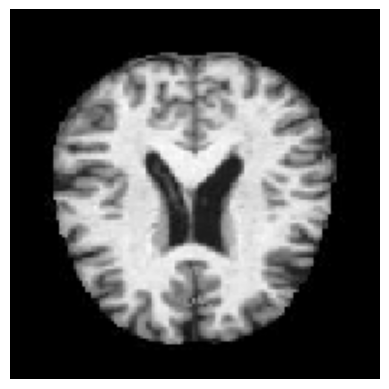

In [88]:
show_gray_image(data[2], TITLE='', AX=None)

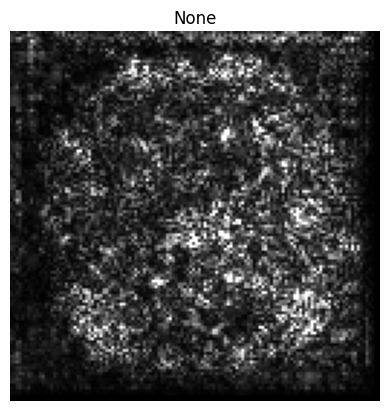

In [89]:
show_gray_image(vanilla_gradient, TITLE='None', AX=None)

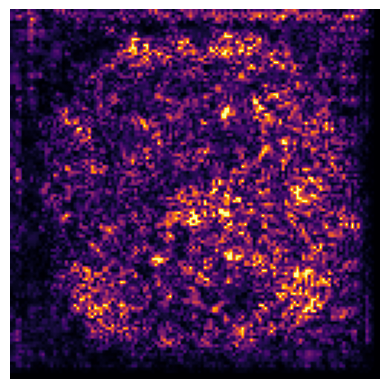

In [112]:
show_heatmap(vanilla_gradient, TITLE='', AX=None)

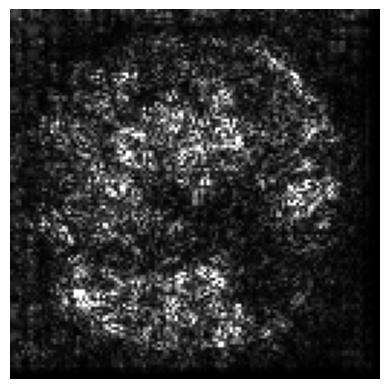

In [110]:
#moderate
vanilla_grad_mod = visualize_tensor(vanilla_grad_mod)
show_gray_image(vanilla_grad_mod, TITLE='', AX=None)

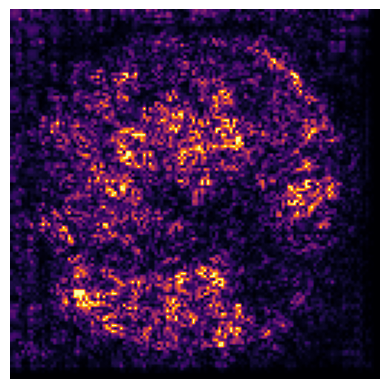

In [111]:
show_heatmap(vanilla_grad_mod, TITLE='', AX=None)

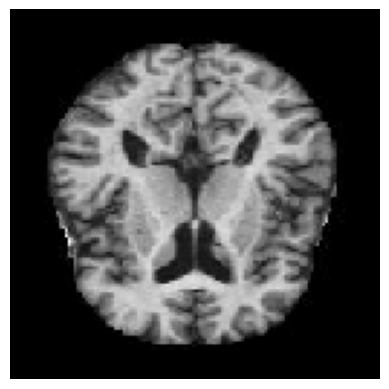

In [113]:
show_gray_image(data[35], TITLE='', AX=None)

## Integrated gradients

In [74]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

In [122]:
io_imgs = load_images_2d(df_o.image_path[0])
#class_id =df_o.image_path[0]
img_name_tensors = tensorflow.convert_to_tensor(io_imgs)

In [ ]:
plt.figure(figsize=(8, 8))
for n, ( img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
  ax = plt.subplot(1, 2, n+1)
  ax.imshow(img_tensors)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()